In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

In [2]:
df = pd.read_csv('candy-production-data.csv', header=0, names=['date','production'])
df['date']= pd.to_datetime(df['date'])

## Split the data
To keep things simple, I'm just using the last full year as the test set. I removed the incomplete year of 2021.

In [5]:
df_train = df[0:576]
df_test = df[576:588]

### A first look at the training data
Definitely very cyclical. Nice upward trend, but it was interruped pretty severely a few years ago. I'm interested to look into that a bit more.

<AxesSubplot:>

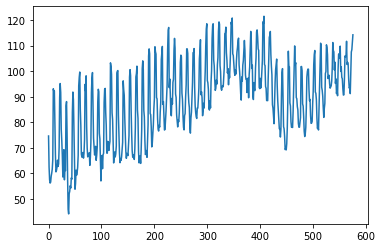

In [9]:
df_train['production'].plot(kind='line')

In [12]:
df_decomp = df_train
df_decomp.set_index('date', inplace=True)

In [13]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_decomp['production'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df_decomp['production'], model='additive', extrapolate_trend='freq')


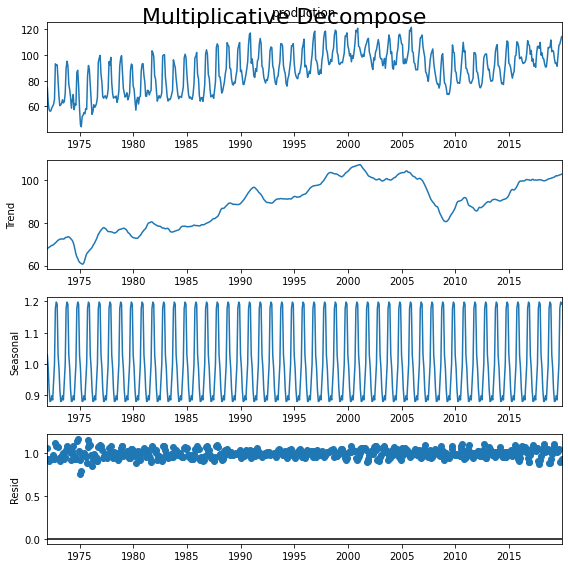

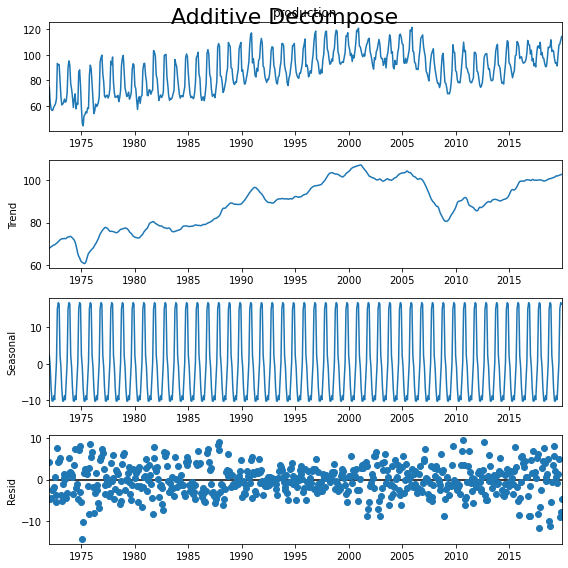

In [17]:
# Plot
plt.rcParams.update({'figure.figsize': (8,8)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

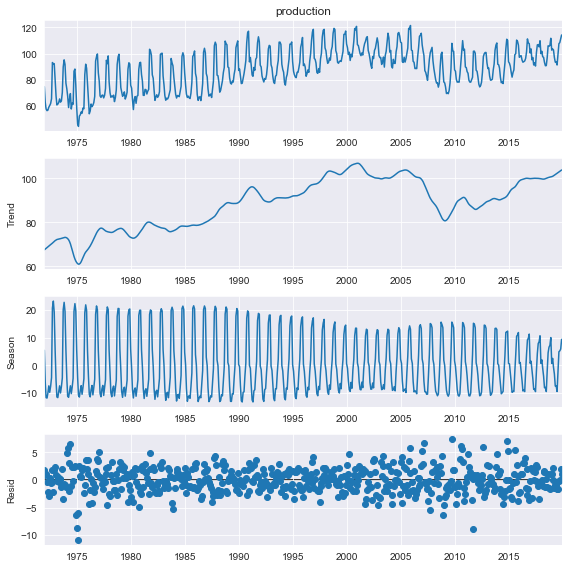

In [22]:
# STL Decomposition
stl = STL(df_decomp['production'], seasonal=13)
res = stl.fit()
fig = res.plot()